https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/


# Load Dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from keras.models import Model
import matplotlib.pyplot as plt
from IPython.display import Image
import gc

# File loading
from google.colab import drive
import pandas as pd
import numpy as np

# General
from scipy import ndimage
from tqdm import tqdm_notebook

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load train & test data
train_df = pd.read_csv("/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/0. Dataset/augmented_data.csv")
test_df = pd.read_csv("/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/0. Dataset/test_data.csv")
val_df = pd.read_csv("/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/0. Dataset/val_data.csv")

In [ ]:
# Load images
import pickle
with open('/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/0. Dataset/preprocessed_images.pkl', 'rb') as f:
  images = pickle.load(f)

In [ ]:
images.head()

,image,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",a
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",a
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",a
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",a
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",a


In [ ]:
# Create a mapping from unique labels to integers
unique_labels = pd.unique(pd.concat([train_df['label'], test_df['label']]))
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# Convert train and test labels to numerical indices
train_df['label_encoded'] = train_df['label'].map(label_to_index).values
test_df['label_encoded'] = test_df['label'].map(label_to_index).values
val_df['label_encoded'] = val_df['label'].map(label_to_index).values

In [ ]:
train_df

,pixel0_0,pixel0_1,pixel0_2,pixel0_3,pixel0_4,pixel0_5,pixel0_6,pixel0_7,pixel0_8,pixel0_9,...,pixel63_56,pixel63_57,pixel63_58,pixel63_59,pixel63_60,pixel63_61,pixel63_62,pixel63_63,label,label_encoded
0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,e,0
1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,e,0
2,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,e,0
3,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,e,0
4,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,e,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,ư,5
9236,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,ư,5
9237,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,ư,5
9238,0.0,0.0,0.062745,0.0,0.050980,0.000000,0.0,0.070588,0.0,0.039216,...,0.000000,0.0,0.019608,0.043137,0.070588,0.000000,0.0,0.086275,ư,5


In [ ]:
X_train = train_df.drop(['label', 'label_encoded'], axis=1)
y_train = train_df['label_encoded']

In [ ]:
X_train.head()

,pixel0_0,pixel0_1,pixel0_2,pixel0_3,pixel0_4,pixel0_5,pixel0_6,pixel0_7,pixel0_8,pixel0_9,...,pixel63_54,pixel63_55,pixel63_56,pixel63_57,pixel63_58,pixel63_59,pixel63_60,pixel63_61,pixel63_62,pixel63_63
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_test = test_df.drop(['label', 'label_encoded'], axis=1)
y_test = test_df['label_encoded']

In [ ]:
X_test

,pixel0_0,pixel0_1,pixel0_2,pixel0_3,pixel0_4,pixel0_5,pixel0_6,pixel0_7,pixel0_8,pixel0_9,...,pixel63_54,pixel63_55,pixel63_56,pixel63_57,pixel63_58,pixel63_59,pixel63_60,pixel63_61,pixel63_62,pixel63_63
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_test

,label_encoded
0,1
1,5
2,4
3,1
4,3
...,...
175,2
176,11
177,9
178,6


# Manual Code

In [ ]:
def process_input(X, y):
  X = np.reshape(X, (X.shape[0], 64, 64, 1))
  y = np.eye(12)[y.to_numpy().reshape(-1)].T
  return X, y

In [ ]:
X_train, y_train = process_input(X_train, y_train)

In [ ]:
X_train.shape # (batch_size, height, width, channel=1 because of grayscale)

(9240, 64, 64, 1)

In [ ]:
y_train.shape # (num_classes, batch_size)

(12, 9240)

In [ ]:
X_test, y_test = process_input(X_test, y_test)

In [ ]:
X_test.shape

(180, 64, 64, 1)

In [ ]:
y_test.shape

(12, 180)

In [ ]:
def conv_forward(x,w,b,padding="same"):

    if padding=="same":
        pad = (w.shape[0]-1)//2
    else: # no zero padding
        pad = 0

    n = (x.shape[1]-w.shape[0]+2*pad) +1 #ouput width/height

    y = np.zeros((x.shape[0],n,n,w.shape[3])) #output array

    #pad input
    x_padded = np.pad(x,((0,0),(pad,pad),(pad,pad),(0,0)),'constant', constant_values = 0)

    #flip filter to cancel out reflection
    w = np.flip(w,0)
    w = np.flip(w,1)

    f = w.shape[0] #size of filter

    for m_i in range(x.shape[0]): #each of the training examples
        for k in range(w.shape[3]): #each of the filters
            for d in range(x.shape[3]): #each slice of the input
                y[m_i,:,:,k]+= ndimage.convolve(x_padded[m_i,:,:,d],w[:,:,d,k])[f//2:-(f//2),f//2:-(f//2)] #sum across depth

    y = y + b #add bias (this broadcasts across image)
    return y

In [ ]:
def conv_backward(dZ,x,w,padding="same"):
    m = x.shape[0]

    db = (1/m)*np.sum(dZ, axis=(0,1,2), keepdims=True)

    if padding=="same":
        pad = (w.shape[0]-1)//2
    else: #padding is valid - i.e no zero padding
        pad =0
    x_padded = np.pad(x,((0,0),(pad,pad),(pad,pad),(0,0)),'constant', constant_values = 0)

    #this will allow us to broadcast operations
    x_padded_bcast = np.expand_dims(x_padded, axis=-1) # shape = (m, i, j, c, 1)
    dZ_bcast = np.expand_dims(dZ, axis=-2) # shape = (m, i, j, 1, k)

    dW = np.zeros_like(w)
    f=w.shape[0]
    w_x = x_padded.shape[1]
    for a in range(f):
        for b in range(f):
            #note f-1 - a rather than f-a since indexed from 0...f-1 not 1...f
            dW[a,b,:,:] = (1/m)*np.sum(dZ_bcast*x_padded_bcast[:,a:w_x-(f-1 -a),b:w_x-(f-1 -b),:,:],axis=(0,1,2))

    dx = np.zeros_like(x_padded,dtype=float)
    Z_pad = f-1
    dZ_padded = np.pad(dZ,((0,0),(Z_pad,Z_pad),(Z_pad,Z_pad),(0,0)),'constant', constant_values = 0)

    for m_i in range(x.shape[0]):
        for k in range(w.shape[3]):
            for d in range(x.shape[3]):
                dx[m_i,:,:,d]+=ndimage.convolve(dZ_padded[m_i,:,:,k],w[:,:,d,k])[f//2:-(f//2),f//2:-(f//2)]
    dx = dx[:,pad:dx.shape[1]-pad,pad:dx.shape[2]-pad,:]
    return dx,dW,db

In [ ]:
def pool_forward(x,mode="max"):
    x_patches = x.reshape(x.shape[0],x.shape[1]//2, 2,x.shape[2]//2, 2,x.shape[3])
    out = x_patches.max(axis=2).max(axis=3)
    mask = np.isclose(x,np.repeat(np.repeat(out,2,axis=1),2,axis=2)).astype(int)
    return out,mask

In [ ]:
def pool_backward(dx, mask):
    return mask*(np.repeat(np.repeat(dx,2,axis=1),2,axis=2))

In [ ]:
def relu(x, deriv=False):
    if deriv:
        return (x>0)
    return np.multiply(x, x>0)

In [ ]:
def fc_forward(x,w,b):
    return relu(w.dot(x)+b)

In [ ]:
def softmax_forward(x,w,b):
    z = w.dot(x)+b
    z -= np.mean(z,axis=0,keepdims=True) #this ensures that the value exponentiated doesn't become too large and overflow
    a = np.exp(z)
    a = a/np.sum(a,axis=0,keepdims=True)
    return a+1e-8 #add 1e-8 to ensure no 0 values - since log 0 is undefined

In [ ]:
def fc_backward(dA,a,x,w,b):
    m = dA.shape[1]
    dZ = dA*relu(a,deriv=True)
    dW = (1/m)*dZ.dot(x.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dx =  np.dot(w.T,dZ)
    return dx, dW,db

In [ ]:
def softmax_backward(y_pred, y, w, b, x):
    m = y.shape[1]
    dZ = y_pred - y
    dW = (1/m)*dZ.dot(x.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dx =  np.dot(w.T,dZ)
    return dx, dW,db

In [ ]:
from tqdm.notebook import tqdm, tqdm_notebook

In [ ]:
class SimpleCNN:
    def __init__(self, learning_rate=0.01):
        # Initialize weights and biases
        # Conv layer 1: 3x3 filters, 1 input channel, 8 filters
        self.W1 = np.random.randn(3, 3, 1, 16) * 0.01
        self.b1 = np.zeros((1, 1, 1, 16))

        # Conv layer 2: 3x3 filters, 16 input channels, 32 filters
        self.W2 = np.random.randn(3, 3, 16, 32) * 0.01
        self.b2 = np.zeros((1, 1, 1, 32))

        # Calculate the size after convolutions and pooling
        # After two 2x2 max pools, spatial dimensions are reduced by factor of 4
        # Final feature map size will be 16x16 with 32 channels
        fc_input_size = 16 * 16 * 32

        # Fully connected layer: (16*16*32) inputs, 128 outputs
        self.W3 = np.random.randn(128, fc_input_size) * 0.01
        self.b3 = np.zeros((128, 1))

        # Output layer: 128 inputs, 12 classes
        self.W4 = np.random.randn(12, 128) * 0.01
        self.b4 = np.zeros((12, 1))

        self.learning_rate = learning_rate

    def forward(self, X):
        # First conv layer + ReLU
        self.Z1 = conv_forward(X, self.W1, self.b1, padding="same")
        self.A1 = relu(self.Z1)

        # First pooling layer
        self.P1, self.M1 = pool_forward(self.A1, mode="max")

        # Second conv layer + ReLU
        self.Z2 = conv_forward(self.P1, self.W2, self.b2, padding="same")
        self.A2 = relu(self.Z2)

        # Second pooling layer
        self.P2, self.M2 = pool_forward(self.A2, mode="max")

        # Reshape for fully connected layer
        self.flat = self.P2.reshape(self.P2.shape[0], -1)  # Shape: (batch_size, 16*16*32)

        # First fully connected layer + ReLU
        self.Z3 = np.dot(self.W3, self.flat.T) + self.b3  # Shape: (128, batch_size)
        self.A3 = relu(self.Z3)

        # Output layer with softmax
        self.Z4 = np.dot(self.W4, self.A3) + self.b4  # Shape: (12, batch_size)
        self.output = np.exp(self.Z4) / np.sum(np.exp(self.Z4), axis=0, keepdims=True)

        return self.output

    def backward(self, X, Y, Y_pred):
        m = X.shape[0]

        # Backprop through softmax layer
        dZ4 = Y_pred - Y  # Shape: (12, batch_size)
        dW4 = (1/m) * np.dot(dZ4, self.A3.T)  # Shape: (12, 128)
        db4 = (1/m) * np.sum(dZ4, axis=1, keepdims=True)  # Shape: (12, 1)

        # Backprop through first FC layer
        dA3 = np.dot(self.W4.T, dZ4)  # Shape: (128, batch_size)
        dZ3 = dA3 * relu(self.Z3, deriv=True)  # Shape: (128, batch_size)
        dW3 = (1/m) * np.dot(dZ3, self.flat)  # Shape: (128, 16*16*32)
        db3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)  # Shape: (128, 1)

        # Reshape back to conv dimensions
        dP2 = np.dot(self.W3.T, dZ3).T.reshape(self.P2.shape)  # Shape: (batch_size, 16, 16, 32)

        # Backprop through second pooling layer
        dA2 = pool_backward(dP2, self.M2)

        # Backprop through second conv layer
        dZ2, dW2, db2 = conv_backward(dA2, self.P1, self.W2)

        # Backprop through first pooling layer
        dA1 = pool_backward(dZ2, self.M1)

        # Backprop through first conv layer
        dX1, dW1, db1 = conv_backward(dA1, X, self.W1)

        # Update weights using gradient descent
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3
        self.W4 -= self.learning_rate * dW4
        self.b4 -= self.learning_rate * db4

    def train(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
        train_losses = []
        test_accuracies = []
        n_batches = X_train.shape[0] // batch_size

        # Create progress bar for epochs
        epoch_pbar = tqdm(range(epochs), desc='Epochs', position=0)

        for epoch in epoch_pbar:
            # Shuffle training data
            indices = np.random.permutation(X_train.shape[0])
            X_train = X_train[indices]
            y_train = y_train[:, indices]

            total_loss = 0
            # Create progress bar for batches within this epoch
            batch_pbar = tqdm(range(0, X_train.shape[0], batch_size),
                            desc=f'Batch Progress',
                            leave=False,
                            position=1)

            for i in batch_pbar:
                # Get current batch
                batch_X = X_train[i:i+batch_size]
                batch_y = y_train[:, i:i+batch_size]

                # Forward pass
                y_pred = self.forward(batch_X)

                # Calculate cross-entropy loss
                loss = -np.mean(np.sum(batch_y * np.log(y_pred + 1e-8), axis=0))
                total_loss += loss

                # Backward pass
                self.backward(batch_X, batch_y, y_pred)

                # Update batch progress bar with current loss
                batch_pbar.set_postfix({'loss': f'{loss:.4f}'})

            # Calculate average loss and accuracy for this epoch
            avg_loss = total_loss / n_batches
            train_losses.append(avg_loss)

            # Evaluate on test set
            test_pred = self.forward(X_test)
            test_acc = np.mean(np.argmax(test_pred, axis=0) == np.argmax(y_test, axis=0))
            test_accuracies.append(test_acc)

            # Update epoch progress bar with summary metrics
            epoch_pbar.set_postfix({
                'avg_loss': f'{avg_loss:.4f}',
                'test_acc': f'{test_acc:.4f}'
            })

        return train_losses, test_accuracies

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/289 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/289 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/289 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/289 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/289 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/289 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/289 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/289 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/289 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/289 [00:00<?, ?it/s]

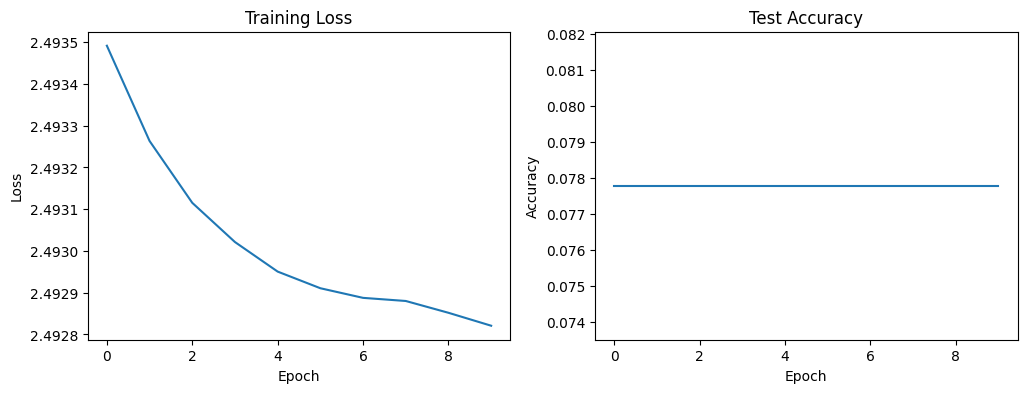

In [ ]:
# Create and train the model
model = SimpleCNN(learning_rate=0.01)
losses, accuracies = model.train(X_train, y_train, X_test, y_test, epochs=10, batch_size=32)

# Plot training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Dataset shapes:
X_train: (60, 8, 8, 1)
y_train: (3, 60)
X_test: (15, 8, 8, 1)
y_test: (3, 15)


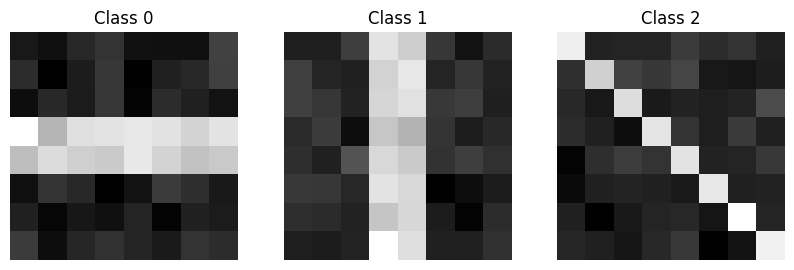

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/6 [00:00<?, ?it/s]

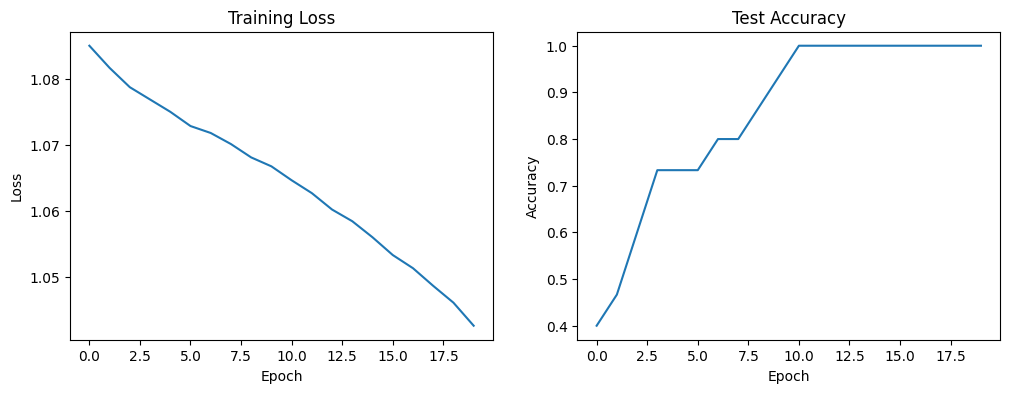

In [ ]:
import numpy as np

# Create a small synthetic dataset
def create_test_dataset():
    # Create 100 training samples and 20 test samples
    # Each image will be 8x8 pixels (smaller than real data for quick testing)
    # We'll create 3 classes with simple patterns

    def create_pattern(n_samples, pattern_type):
        images = np.zeros((n_samples, 8, 8, 1))

        for i in range(n_samples):
            if pattern_type == 0:
                # Horizontal line pattern
                images[i, 3:5, :, 0] = 1
            elif pattern_type == 1:
                # Vertical line pattern
                images[i, :, 3:5, 0] = 1
            elif pattern_type == 2:
                # Diagonal line pattern
                np.fill_diagonal(images[i, :, :, 0], 1)
                np.fill_diagonal(images[i, :, :, 0], 1)

            # Add some random noise
            images[i] += np.random.normal(0, 0.1, (8, 8, 1))

        return images

    # Create training data
    n_train_per_class = 20
    X_train = np.vstack([
        create_pattern(n_train_per_class, 0),
        create_pattern(n_train_per_class, 1),
        create_pattern(n_train_per_class, 2)
    ])

    # Create one-hot encoded labels for training
    y_train = np.zeros((3, n_train_per_class * 3))
    for i in range(3):
        y_train[i, i*n_train_per_class:(i+1)*n_train_per_class] = 1

    # Create test data
    n_test_per_class = 5
    X_test = np.vstack([
        create_pattern(n_test_per_class, 0),
        create_pattern(n_test_per_class, 1),
        create_pattern(n_test_per_class, 2)
    ])

    # Create one-hot encoded labels for test
    y_test = np.zeros((3, n_test_per_class * 3))
    for i in range(3):
        y_test[i, i*n_test_per_class:(i+1)*n_test_per_class] = 1

    return X_train, y_train, X_test, y_test

# Create small dataset
X_train_small, y_train_small, X_test_small, y_test_small = create_test_dataset()

# Let's modify our CNN slightly for this smaller dataset
class SmallCNN(SimpleCNN):
    def __init__(self, learning_rate=0.01):
        # Conv layer 1: 3x3 filters, 1 input channel, 8 filters (reduced from 16)
        self.W1 = np.random.randn(3, 3, 1, 8) * 0.1
        self.b1 = np.zeros((1, 1, 1, 8))

        # Conv layer 2: 3x3 filters, 8 input channels, 16 filters (reduced from 32)
        self.W2 = np.random.randn(3, 3, 8, 16) * 0.1
        self.b2 = np.zeros((1, 1, 1, 16))

        # Calculate the size after convolutions and pooling
        # Input is 8x8, after two 2x2 max pools it becomes 2x2
        fc_input_size = 2 * 2 * 16

        # Fully connected layer: reduced size
        self.W3 = np.random.randn(32, fc_input_size) * 0.1
        self.b3 = np.zeros((32, 1))

        # Output layer: 3 classes
        self.W4 = np.random.randn(3, 32) * 0.1
        self.b4 = np.zeros((3, 1))

        self.learning_rate = learning_rate

# Create and train the model on small dataset
print("Dataset shapes:")
print(f"X_train: {X_train_small.shape}")
print(f"y_train: {y_train_small.shape}")
print(f"X_test: {X_test_small.shape}")
print(f"y_test: {y_test_small.shape}")

# Visualize a few examples
plt.figure(figsize=(10, 3))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(X_train_small[i*20, :, :, 0], cmap='gray')
    plt.title(f'Class {i}')
    plt.axis('off')
plt.show()

# Train the model
model = SmallCNN(learning_rate=0.01)
losses, accuracies = model.train(X_train_small, y_train_small,
                               X_test_small, y_test_small,
                               epochs=20, batch_size=10)

# Plot training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Built-in Library

In [ ]:
# Add Conv + Pooling layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(12, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         589,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 646,412 (2.47 MB)

 Trainable params: 646,412 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

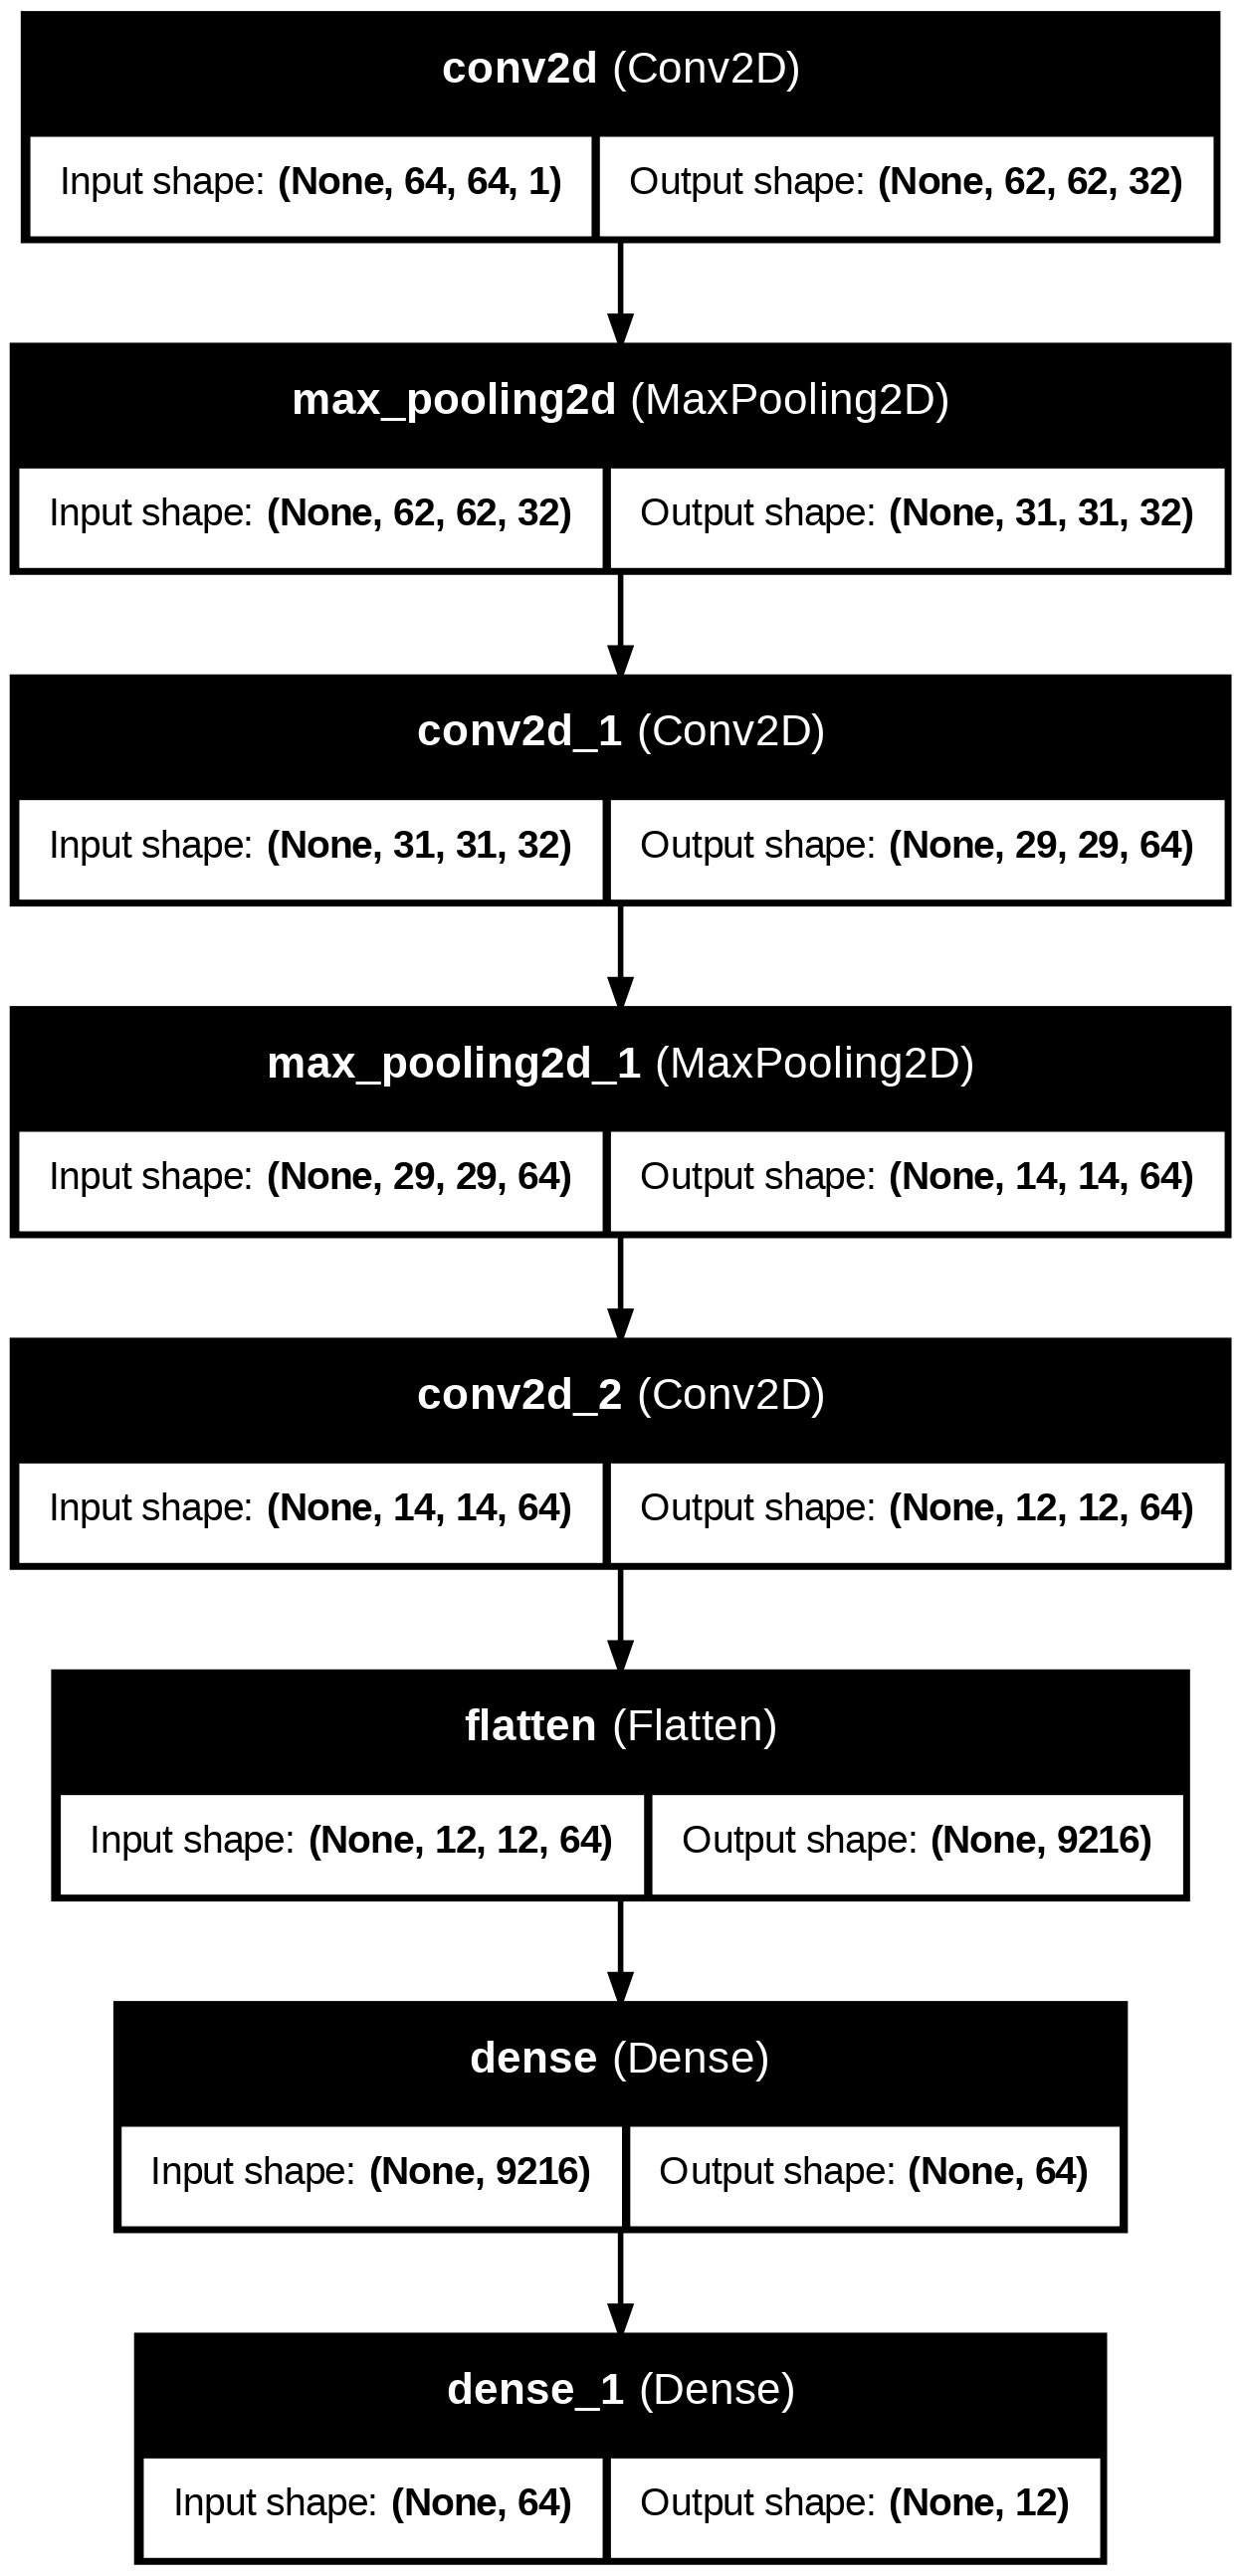

In [ ]:
# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image('model_plot.png')

In [ ]:
train_images = train_df.drop(['label', 'label_encoded'], axis=1).values
train_images = train_images.reshape(-1, 64, 64, 1)
train_labels = train_df['label_encoded'].values

test_images = test_df.drop(['label', 'label_encoded'], axis=1).values
test_images = test_images.reshape(-1, 64, 64, 1)
test_labels = test_df['label_encoded'].values

val_images = val_df.drop(['label', 'label_encoded'], axis=1).values
val_images = val_images.reshape(-1, 64, 64, 1)
val_labels = val_df['label_encoded'].values

In [ ]:
# Compile & train model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

start_time = time.time()
history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(val_images, val_labels))
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


289/289 ━━━━━━━━━━━━━━━━━━━━ 64s 214ms/step - accuracy: 0.8395 - loss: 0.5248 - val_accuracy: 0.9889 - val_loss: 0.0605
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 73s 183ms/step - accuracy: 0.9895 - loss: 0.0387 - val_accuracy: 0.9889 - val_loss: 0.0167
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 85s 193ms/step - accuracy: 0.9919 - loss: 0.0254 - val_accuracy: 0.9944 - val_loss: 0.0061
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 81s 192ms/step - accuracy: 0.9977 - loss: 0.0092 - val_accuracy: 1.0000 - val_loss: 7.8768e-04
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 81s 187ms/step - accuracy: 0.9994 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 87s 205ms/step - accuracy: 1.0000 - loss: 7.1094e-05 - val_accuracy: 1.0000 - val_loss: 7.8730e-04
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 53s 183ms/step - accuracy: 1.0000 - loss: 2.7957e-05 - val_accuracy: 1.0000 - val_loss: 8.4423e-04
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 56s 192ms/step - accuracy: 1.0000 

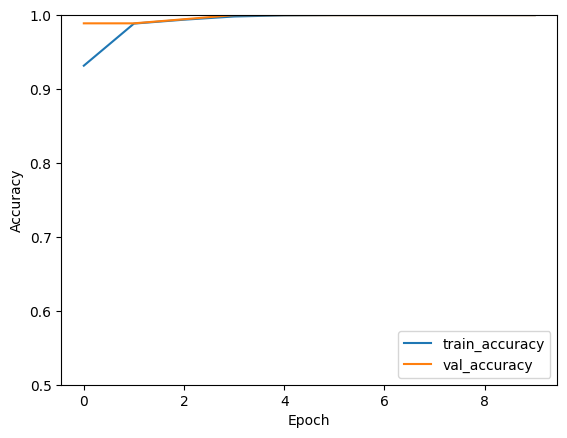

In [ ]:
# Evaluate model
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
start_test_time = time.time()
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
end_test_time = time.time()
print(f"Testing time: {end_test_time - start_test_time} seconds")
print(f"Test accuracy: {test_acc}")

6/6 - 0s - 45ms/step - accuracy: 1.0000 - loss: 2.6874e-05


(2.687444066395983e-05, 1.0)

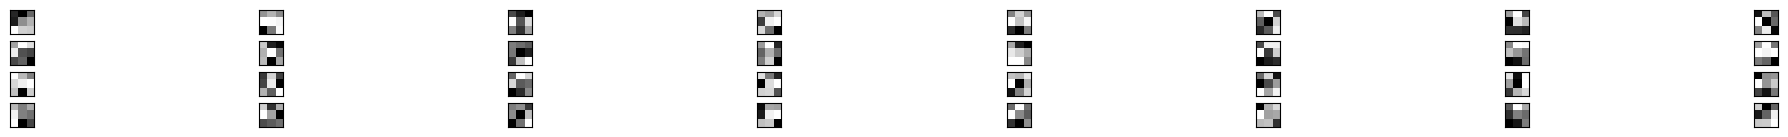

In [ ]:
filters, biases = model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 32, 1

plt.figure(figsize=(20, 10))
for i in range(n_filters):
  f = filters[:, :, :, i]
  for j in range(1):
    ax = plt.subplot(n_filters, 8, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f[:, :, j], cmap='gray')
    ix += 1

plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
for i in range(len(model.layers)):
  layer = model.layers[i]
  if 'conv' in layer.name:
    print(i, layer.name, layer.output.shape)

0 conv2d (None, 62, 62, 32)
2 conv2d_1 (None, 29, 29, 64)
4 conv2d_2 (None, 12, 12, 64)


In [ ]:
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [ ]:
sample_image = test_images[0]
sample_image = np.expand_dims(sample_image, axis=0)

In [ ]:
sample_image.shape

(1, 64, 64, 1)

In [ ]:
feature_maps = model.predict(sample_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


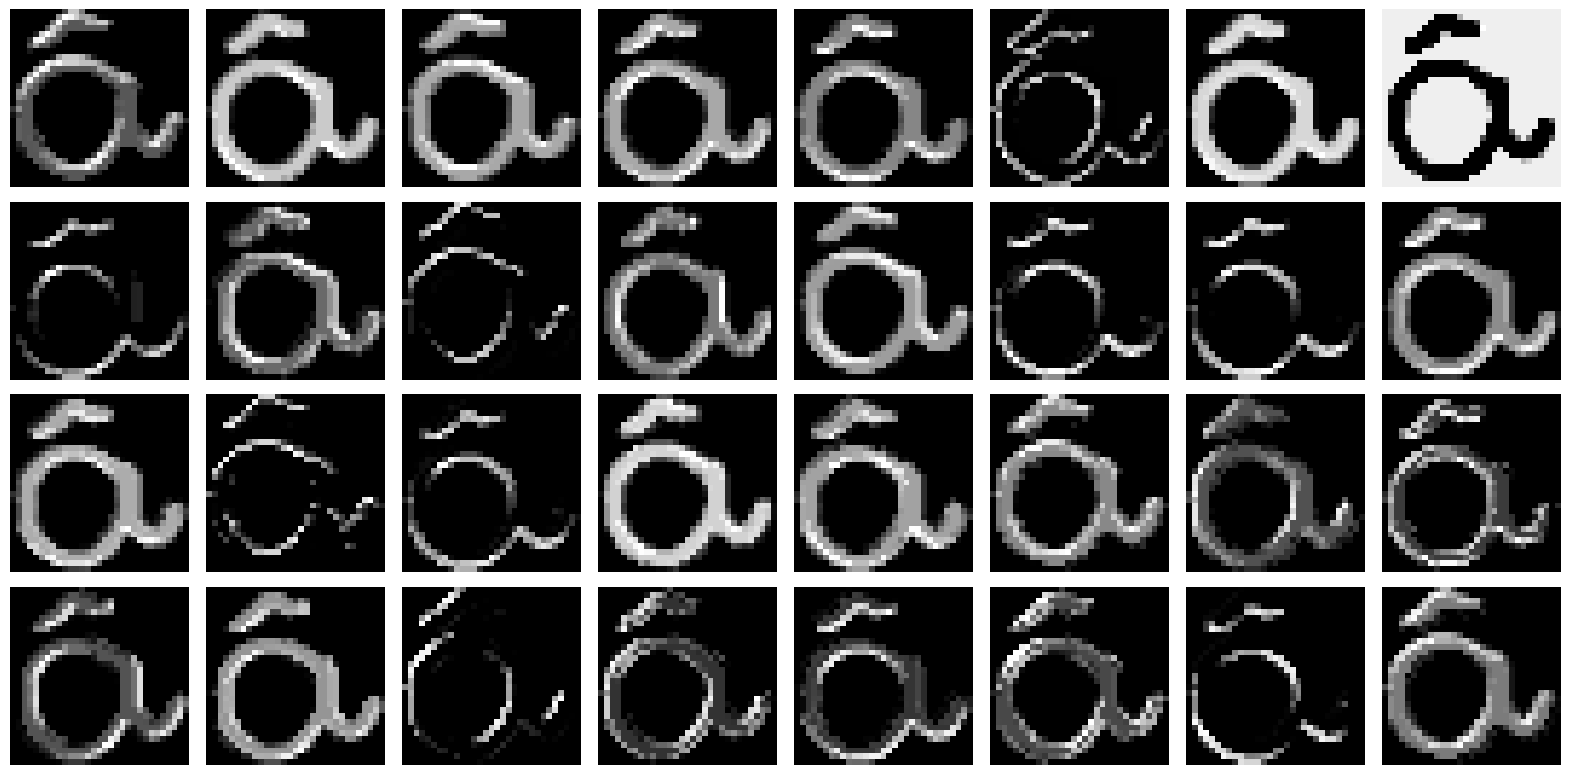

In [ ]:
# Plot 32 feature maps
plt.figure(figsize=(20, 10))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(feature_maps[0, :, :, i], cmap='gray')
    plt.axis('off')

plt.subplots_adjust(hspace=0, wspace=0.1)
plt.show()